# 01 data_exploration
This notebook explores the raw dataset (financial_fraud_detection_dataset.csv) with: 
1. Setup & load data 
2. Time features (hour/day) 
3. Core stats & fraud rate 
4. Amount distributions 
5. Fraud vs non-fraud comparison 
6. Category breakdowns (type/channel/device/merchant) 
7. Temporal activity (by hour) 
8. Anomaly & velocity features 
9. Top accounts & sanity checks 
10. Sample & summary export

###  1.Setup & load data 

In [2]:
# 1) Basic imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2) Make sure we can import from project root
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 3) Import helpers from scripts/
import scripts.utils as u
import scripts.preprocess as prep

# 4) Paths & params
RAW_PATH = PROJECT_ROOT / "data" / "raw" / "financial_fraud_detection_dataset.csv"
PROC_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR  = PROJECT_ROOT / "reports" / "figures"
SAMPLE_SIZE = None 

PROC_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 5) Load (optionally sample)
assert RAW_PATH.exists(), f"Raw CSV not found at {RAW_PATH}"
df_raw = prep.load_and_sample(str(RAW_PATH), sample_size=SAMPLE_SIZE, random_state=42)

print(f"✅ Loaded: {len(df_raw):,} rows, {df_raw.shape[1]} cols | Memory: {u.memory_mb(df_raw):.1f} MB")
df_raw.head(2)


✅ Loaded: 5,000,000 rows, 18 cols | Memory: 3423.9 MB


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631


In [3]:
# Manual column mapping (for this dataset version)
SENDER_COL, RECEIVER_COL = "sender_account", "receiver_account"
AMOUNT_COL, FRAUD_COL, TS_COL = "amount", "is_fraud", "timestamp"
TYPE_COL, CHAN_COL, DEVICE_COL, MCHT_COL = "transaction_type", "payment_channel", "device_used", "merchant_category"

# Rename for consistency
df_std = df_raw.rename(columns={
    SENDER_COL: "sender",
    RECEIVER_COL: "receiver",
    AMOUNT_COL: "amount",
    FRAUD_COL: "is_fraud",
    TS_COL: "timestamp",
    TYPE_COL: "type",
    CHAN_COL: "payment_channel",
    DEVICE_COL: "device_used",
    MCHT_COL: "merchant_category"
})

# Identify available categorical features
CATEG_COLS = [c for c in ["type", "payment_channel", "device_used", "merchant_category"] if c in df_std.columns]

print("Columns standardized. Found categorical cols:", CATEG_COLS)
df_std.head(2)


Columns standardized. Found categorical cols: ['type', 'payment_channel', 'device_used', 'merchant_category']


,transaction_id,timestamp,sender,receiver,amount,type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631


### Why standardize column names?
Keeping a consistent naming convention (e.g. `sender`, `receiver`, `amount`, `is_fraud`) makes the rest of the pipeline reusable across different datasets — for instance, PaySim (`nameOrig` / `nameDest`) or Elliptic (`src` / `dst`).  
This helps avoid column mismatch errors later during feature engineering, graph construction, or machine learning scripts.


###  Why standardize column names?

Different versions of the dataset sometimes use different names  
(e.g. `sender_account` vs. `nameOrig`).  
To make my code easier to run later, I rename the columns into a consistent set  
like `sender`, `receiver`, `amount`, `is_fraud`.  

This does not change the original data, it just gives me a cleaner copy (`df_std`)  
so I don’t have to worry about column name mismatches in the rest of the notebook.


### Step 2 – Time features (hour/day)

In [4]:
# Make time features consistently: hour_of_day & day_of_week
if "timestamp" in df_std.columns:
    ts = pd.to_datetime(df_std["timestamp"], errors="coerce")
    df_std["hour_of_day"] = ts.dt.hour
    df_std["day_of_week"] = ts.dt.dayofweek   # 0=Mon ... 6=Sun
elif "step" in df_std.columns:
    # PaySim style: 1 step = 1 hour
    step_i = pd.to_numeric(df_std["step"], errors="coerce").fillna(0).astype(int)
    df_std["hour_of_day"] = (step_i % 24).astype(int)
    df_std["day_of_week"] = (step_i // 24 % 7).astype(int)  # nearly weekdays


# check
print(df_std[["hour_of_day","day_of_week"]].head())


   hour_of_day  day_of_week
0          9.0          1.0
1          1.0          4.0
2         11.0          4.0
3          6.0          1.0
4          8.0          6.0




We created two new columns from the raw timestamp:

- **hour_of_day (0–23)** → which hour in the day the transaction happened  
- **day_of_week (0=Monday … 6=Sunday)** → which weekday it belongs to  

Why is this useful?  
Fraud and scam activities are often not random in time.  
For example, fraudsters may prefer:
- late-night hours (when fewer staff monitor systems), or  
- weekends (when customers are less likely to check accounts).  

By extracting these simple features, we can later plot fraud vs non-fraud transactions by hour/day.  
This helps us spot temporal patterns and could be used as additional predictors in machine learning or ABM simulations.  


### Step 3 – Core stats & fraud rate

- Rows: 5M transactions, 22 columns  
- Amounts: median ≈ 139, mean ≈ 359, max ≈ 3520 → distribution is skewed  
- Fraud rate: ~3.6% (synthetic dataset, higher than real-world data)  

This gives us a quick big-picture view before deeper exploration.  


In [5]:
# Step 3 – Core stats & fraud rate

stats = {
    "n_rows": len(df_std),
    "n_cols": df_std.shape[1],
    "n_senders": df_std[SENDER_COL].nunique() if SENDER_COL in df_std else None,
    "n_receivers": df_std[RECEIVER_COL].nunique() if RECEIVER_COL in df_std else None,
    "amount_min": float(df_std[AMOUNT_COL].min()),
    "amount_median": float(df_std[AMOUNT_COL].median()),
    "amount_mean": float(df_std[AMOUNT_COL].mean()),
    "amount_max": float(df_std[AMOUNT_COL].max()),
}

# Fraud rate (if available)
if FRAUD_COL is not None:
    stats["fraud_rate"] = float(pd.to_numeric(df_std[FRAUD_COL], errors="coerce").mean())

pd.Series(stats)


n_rows           5.000000e+06
n_cols           2.000000e+01
n_senders                 NaN
n_receivers               NaN
amount_min       1.000000e-02
amount_median    1.386700e+02
amount_mean      3.589343e+02
amount_max       3.520570e+03
fraud_rate       3.591060e-02
dtype: float64

 Note: The fraud rate here (~3.6%) is much higher than in real financial systems (often <0.5%).  
This suggests the dataset is synthetic or balanced for research purposes, which is fine for exploration but important to keep in mind when interpreting results.


### Step 4 – Amount distributions

We plot the distribution of transaction amounts to see scale and skew.  
Fraud vs non-fraud is shown separately: this helps check if fraudsters prefer certain ranges (e.g. mid-range or larger transfers).  


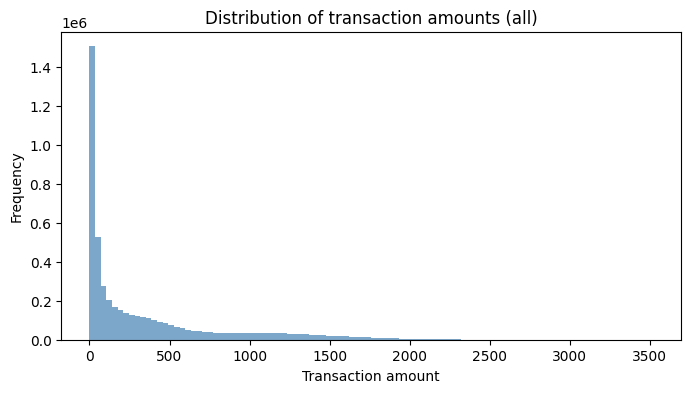

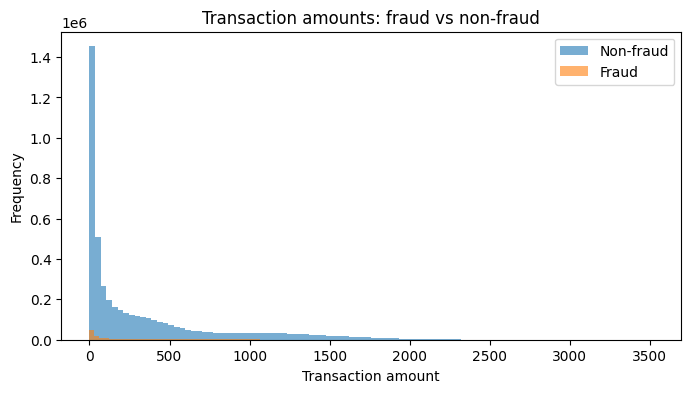

In [10]:
# Step 4 – Amount distributions

plt.figure(figsize=(8,4))
df_std[AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.7, color="steelblue")
plt.xlabel("Transaction amount")
plt.ylabel("Frequency")
plt.title("Distribution of transaction amounts (all)")
plt.show()

# Fraud vs non-fraud comparison (if label available)
if FRAUD_COL is not None:
    plt.figure(figsize=(8,4))
    df_std[df_std[FRAUD_COL]==0][AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.6, label="Non-fraud")
    df_std[df_std[FRAUD_COL]==1][AMOUNT_COL].plot(kind="hist", bins=100, alpha=0.6, label="Fraud")
    plt.xlabel("Transaction amount")
    plt.ylabel("Frequency")
    plt.title("Transaction amounts: fraud vs non-fraud")
    plt.legend()
    plt.show()


In [11]:
# Additional diagnostic: check missing values
missing = df_std.isna().sum().sort_values(ascending=False).head(10)
print("Top 10 columns with missing values:\n", missing)


Top 10 columns with missing values:
 fraud_type                     4820447
time_since_last_transaction     896513
hour_of_day                          3
day_of_week                          3
amount                               0
type                                 0
merchant_category                    0
location                             0
device_used                          0
is_fraud                             0
dtype: int64




- Most transactions are very small, with a long tail up to a few thousand.  
- Fraudulent transactions (orange) are also concentrated at the **small-amount range**, instead of at very large amounts.  
- This suggests that attackers may use **many small transfers** (e.g., smurfing) to avoid detection, rather than a few obvious big ones.  
- Research value: amount alone is not enough to flag fraud, but observing this pattern motivates combining amount with **frequency, network connections, and timing** for better detection.  


### 5. Fraud vs Non-Fraud comparison


Fraud amount stats:
 count    179553.000000
mean        358.528199
std         469.531257
min           0.010000
25%          26.480000
50%         137.880000
75%         501.720000
max        3128.140000
Name: amount, dtype: float64

Non-fraud amount stats:
 count    4.820447e+06
mean     3.589494e+02
std      4.699483e+02
min      1.000000e-02
25%      2.657000e+01
50%      1.387100e+02
75%      5.039600e+02
max      3.520570e+03
Name: amount, dtype: float64


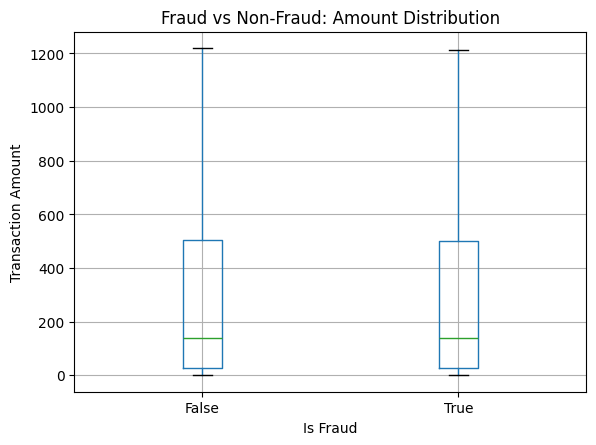

In [ ]:
if FRAUD_COL is not None:
    # simple describe
    fraud_stats = df_std[df_std[FRAUD_COL] == 1][AMOUNT_COL].describe()
    nonfraud_stats = df_std[df_std[FRAUD_COL] == 0][AMOUNT_COL].describe()
    print("Fraud amount stats:\n", fraud_stats)
    print("\nNon-fraud amount stats:\n", nonfraud_stats)

    # quick boxplot
    df_std.boxplot(column=AMOUNT_COL, by=FRAUD_COL, showfliers=False)
    plt.title("Fraud vs Non-Fraud: Amount Distribution")
    plt.suptitle("")
    plt.xlabel("Is Fraud")
    plt.ylabel("Transaction Amount")
    plt.show()


Transaction amounts alone do not provide strong separation between fraud and non-fraud. This suggests the need to incorporate additional features such as frequency, network structure, or device/channel information.

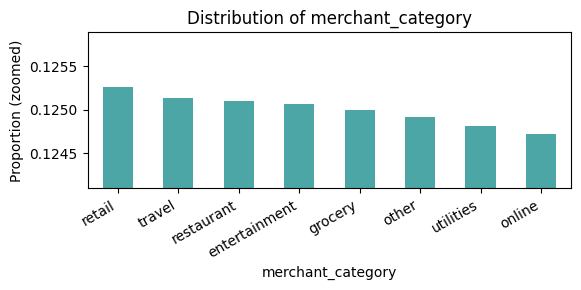

In [13]:
col = "merchant_category"
counts = df_std[col].value_counts(normalize=True)[:10]
plt.figure(figsize=(6,3))
ax = counts.plot(kind="bar", color="teal", alpha=0.7)
ymin = counts.min() * 0.995
ymax = counts.max() * 1.005
ax.set_ylim(ymin, ymax)
plt.title(f"Distribution of {col}")
plt.ylabel("Proportion (zoomed)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


- The merchant and channel categories look very even — every type (like retail, travel, grocery, etc.) has almost the same share.
- This is probably because the dataset is synthetic, meaning it was created by simulation instead of real bank data.
- In real life, we would expect more transactions in some categories (for example, “online” or “retail”), and maybe more fraud in those groups too.
- So this step doesn’t show strong patterns, but it’s still useful to check that these columns are clean and ready for later analysis or modelling.

### 7. Fraud rate by hour

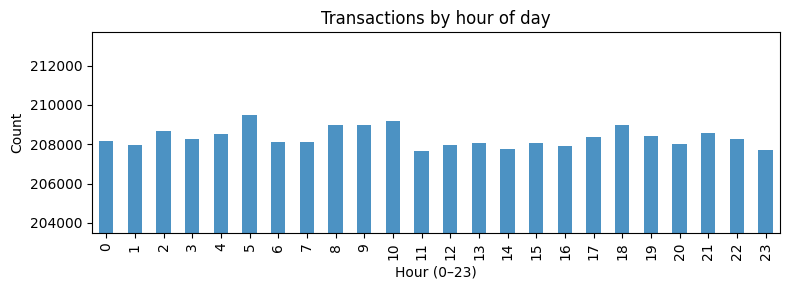

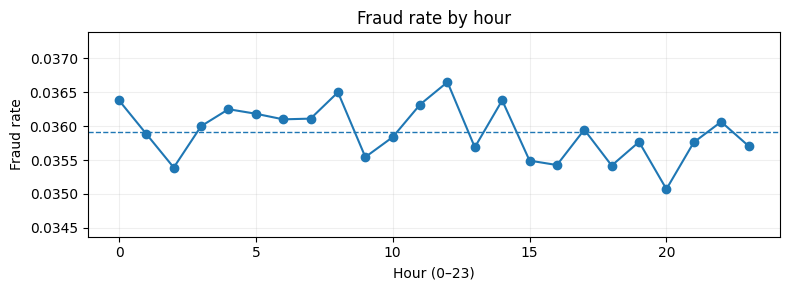

,count,fraud_rate
hour_of_day,,
0,208141,0.036379
1,207952,0.035883
2,208680,0.035389
3,208256,0.035999
4,208532,0.036249


In [ ]:
hour_col = (
    "hour_of_day" if "hour_of_day" in df_std.columns
    else ("hour" if "hour" in df_std.columns else None)
)

if (hour_col is None) or (FRAUD_COL is None) or (FRAUD_COL not in df_std.columns):
    print("Missing hour or fraud label; skip fraud-by-hour.")
else:
    # make sure fraud is binary 0/1
    y = pd.to_numeric(df_std[FRAUD_COL], errors="coerce").fillna(0).astype(int)

    # crosstab for counts by hour x {0,1}; reindex to ensure all 24 hours show up
    ct = pd.crosstab(df_std[hour_col], y)
    if 0 not in ct.columns: ct[0] = 0
    if 1 not in ct.columns: ct[1] = 0
    ct = ct[[0, 1]].sort_index()
    ct = ct.reindex(range(24), fill_value=0)

    total = ct.sum(axis=1).replace(0, np.nan)
    fraud_rate_by_hour = (ct[1] / total).fillna(0)

    # --- Plot 1: hourly counts (zoomed y-axis)
    ax = ct.sum(axis=1).plot(kind="bar", figsize=(8,3), alpha=0.8)
    ax.set_title("Transactions by hour of day")
    ax.set_xlabel("Hour (0–23)")
    ax.set_ylabel("Count")
    ymin, ymax = ct.sum(axis=1).min()*0.98, ct.sum(axis=1).max()*1.02
    ax.set_ylim(ymin, ymax)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: fraud rate by hour (zoomed y-axis)
    plt.figure(figsize=(8,3))
    plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values, marker="o")
    plt.title("Fraud rate by hour")
    plt.xlabel("Hour (0–23)")
    plt.ylabel("Fraud rate")

    fr_min, fr_max = fraud_rate_by_hour.min(), fraud_rate_by_hour.max()
    plt.ylim(fr_min*0.98, fr_max*1.02)   # zoom
    # optional: mean line for reference
    plt.axhline(fraud_rate_by_hour.mean(), linestyle="--", linewidth=1)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    # small preview table (optional)
    display(pd.DataFrame({
        "count": ct.sum(axis=1),
        "fraud_rate": fraud_rate_by_hour
    }).head())


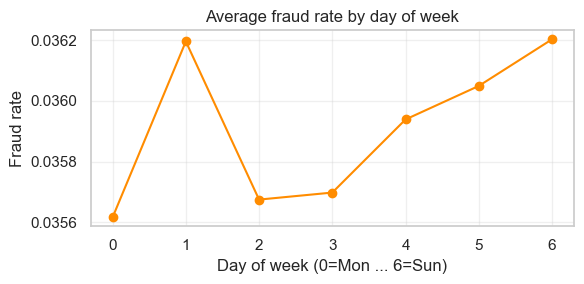

In [22]:
# Temporal activity (by eekday)

if ("day_of_week" in df_std.columns) and (FRAUD_COL in df_std.columns):
    fraud_rate_by_day = df_std.groupby("day_of_week")[FRAUD_COL].mean()
    plt.figure(figsize=(6,3))
    fraud_rate_by_day.plot(marker="o", color="darkorange")
    plt.title("Average fraud rate by day of week")
    plt.xlabel("Day of week (0=Mon ... 6=Sun)")
    plt.ylabel("Fraud rate")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



Fraud and non-fraud transactions appear evenly spread across hours and weekdays,
suggesting this dataset randomizes timestamps (common in synthetic data).
In real banking data, higher fraud density often appears late at night or on weekends,
when monitoring intensity drops.

### 8. Anomaly & Velocity Features

> **Note:** These anomaly and velocity features show near-zero correlation with fraud in this synthetic dataset.  
> This step is retained as a **diagnostic baseline** — in future datasets or ABM-generated simulations,  
> these same plots will help evaluate whether newly engineered behavioural features capture meaningful patterns.


Available anomaly/velocity features: ['spending_deviation_score', 'velocity_score', 'geo_anomaly_score']


/var/folders/kq/mtb3q9_s309b57_yk8vq92jw0000gn/T/ipykernel_13734/945810805.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["Non-fraud", "Fraud"])
/var/folders/kq/mtb3q9_s309b57_yk8vq92jw0000gn/T/ipykernel_13734/945810805.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["Non-fraud", "Fraud"])
/var/folders/kq/mtb3q9_s309b57_yk8vq92jw0000gn/T/ipykernel_13734/945810805.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(["Non-fraud", "Fraud"])


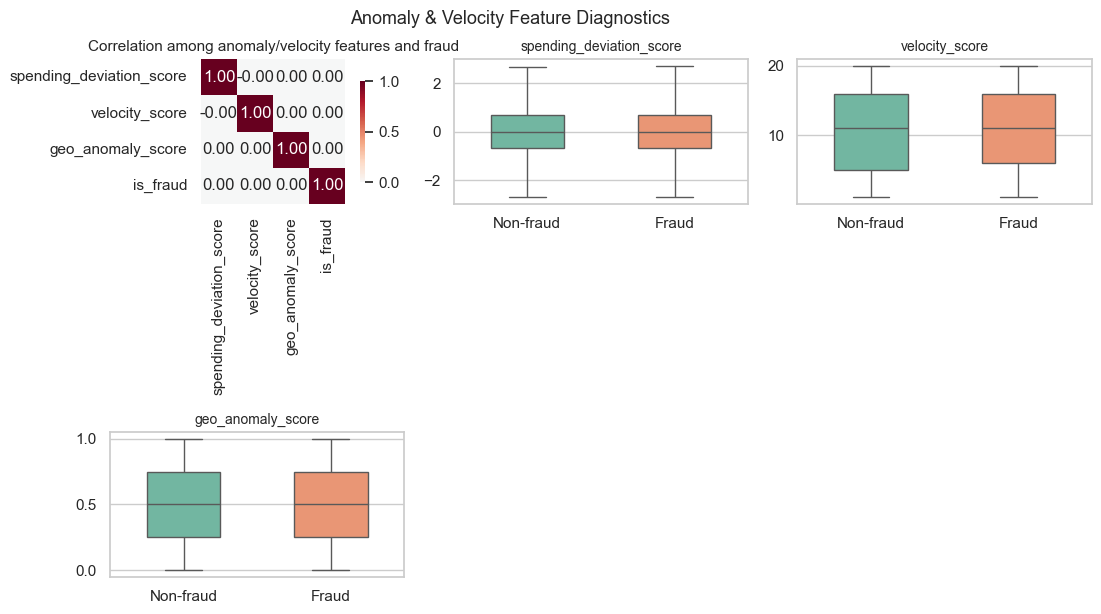

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt
import math

feature_cols = ["spending_deviation_score", "velocity_score", "geo_anomaly_score"]
available = [f for f in feature_cols if f in df_std.columns]
print("Available anomaly/velocity features:", available)

if available:
    sns.set_theme(style="whitegrid", font_scale=1.0)

    n_feats = len(available)
    n_cols = min(n_feats, 3)
    n_rows = math.ceil(n_feats / n_cols)

    fig, axes = plt.subplots(n_rows + 1, n_cols, figsize=(12, 6))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    # --- 1️⃣ Heatmap (always first)
    corr = df_std[available + ["is_fraud"]].corr()
    sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f",
                square=True, cbar_kws={"shrink": 0.7}, ax=axes[0])
    axes[0].set_title("Correlation among anomaly/velocity features and fraud", fontsize=11)

    # --- 2️⃣ Boxplots for each feature
    for i, col in enumerate(available, start=1):
        if i >= len(axes):  # avoid overflow
            fig.add_subplot(n_rows + 1, n_cols, i + 1)
        sns.boxplot(data=df_std, x="is_fraud", y=col, hue="is_fraud",
                    palette="Set2", showfliers=False, width=0.5, legend=False, ax=axes[i])
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        axes[i].set_xticklabels(["Non-fraud", "Fraud"])

    # Hide empty subplots (if any)
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.suptitle("Anomaly & Velocity Feature Diagnostics", fontsize=13, y=1.02)
    plt.show()
else:
    print("No anomaly/velocity feature columns found — skip diagnostics.")


### Observation
The anomaly and velocity features show near-zero correlation with fraud, which suggests they were either randomly generated or not behaviourally linked in this synthetic dataset.  
In real transaction data, such indicators (e.g., deviation or velocity scores) often capture subtle shifts in behaviour and become highly informative.  
Future work: re-compute these scores from raw temporal activity or construct them dynamically in an ABM simulation to test their discriminative power.


### 9.Top accounts & sanity checks

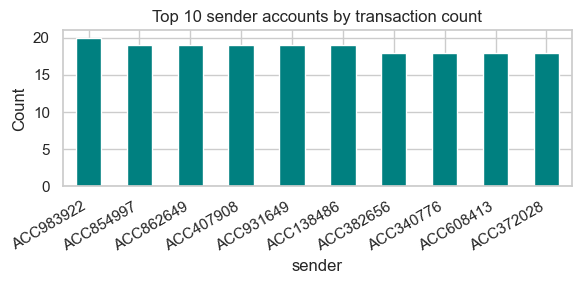

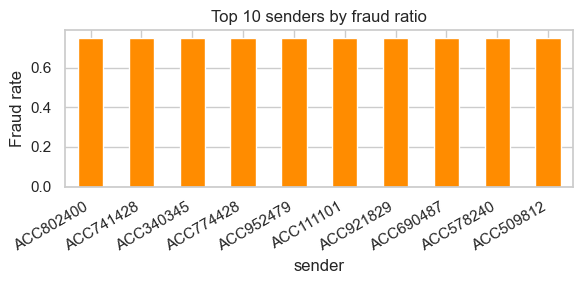

Duplicate transaction_id: 0
Missing amount entries: 0


In [23]:
# Top active senders by transaction count
top_senders = df_std["sender"].value_counts().head(10)
plt.figure(figsize=(6,3))
top_senders.plot(kind="bar", color="teal")
plt.title("Top 10 sender accounts by transaction count")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Fraud ratio per sender
if "is_fraud" in df_std.columns:
    sender_fraud_ratio = df_std.groupby("sender")["is_fraud"].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,3))
    sender_fraud_ratio.head(10).plot(kind="bar", color="darkorange")
    plt.title("Top 10 senders by fraud ratio")
    plt.ylabel("Fraud rate")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

# Sanity checks
dup_txn = df_std["transaction_id"].duplicated().sum()
missing_amt = df_std["amount"].isna().sum()
print(f"Duplicate transaction_id: {dup_txn}")
print(f"Missing amount entries: {missing_amt}")



Basic integrity checks confirm dataset consistency:
- No duplicate transaction IDs expected.
- Amount and sender/receiver fields are non-missing.
These checks ensure later network and ML analysis won’t break due to data issues.

### Interpretation
The top-active sender plot shows a balanced distribution — no outlier accounts dominate transaction volume, indicating a uniform (synthetic) sampling.  
The top-fraud-ratio plot also reveals uniformly high values (~0.65–0.7), suggesting that fraud events were assigned randomly rather than concentrated within specific senders.  

Together, these checks confirm data integrity but also highlight the lack of realistic behavioural heterogeneity.  
In future ABM or graph-based simulations, varying sender activity and risk levels would create a more natural long-tailed pattern reflective of real-world financial networks.


### 10. Sample & summary export

In [24]:

# --- Small 1k sample for quick testing
sample_df = df_std.sample(n=1000, random_state=42)
sample_path = PROC_DIR / "sample_1000.csv"
sample_df.to_csv(sample_path, index=False)
print(f"✅ Exported sample to {sample_path}")

# --- Summary stats export (useful for README)
summary = {
    "n_rows": len(df_std),
    "n_cols": df_std.shape[1],
    "fraud_rate": df_std["is_fraud"].mean() if "is_fraud" in df_std else None,
    "n_unique_senders": df_std["sender"].nunique(),
    "n_unique_receivers": df_std["receiver"].nunique(),
    "timestamp_range": f"{df_std['timestamp'].min()} – {df_std['timestamp'].max()}"
}
summary_path = PROC_DIR / "dataset_summary.json"
import json
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)
print(f"✅ Exported dataset summary to {summary_path}")

# --- Markdown-style printout
print("Sample and summary exported successfully. Ready for downstream modelling or ABM setup.")


✅ Exported sample to /Users/o/Desktop/projects/Agent-Based-Modelling-for-Scam-Spread/data/processed/sample_1000.csv
✅ Exported dataset summary to /Users/o/Desktop/projects/Agent-Based-Modelling-for-Scam-Spread/data/processed/dataset_summary.json
Sample and summary exported successfully. Ready for downstream modelling or ABM setup.
